# Setups, Installations and Imports



```
# This is formatted as code
```

This loss landscape analysis following the idea in "Loss Surfaces, Mode Connectivity, and Fast Ensembling of DNNs " https://arxiv.org/pdf/1802.10026.pdf

Pytorch code is available here: https://github.com/timgaripov/dnn-mode-connectivity but it has not been used 


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications import resnet50


In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import io
import itertools
from sklearn.metrics import confusion_matrix

# Download and Prepare Dataset

#### MNIST

#### Dataloader

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

CLASS_NAMES = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

from sklearn.utils import shuffle
x_test, y_test = shuffle(x_test, y_test)
test_image_len=500
x_test = x_test[:test_image_len,:,:]
y_test = y_test[:test_image_len]


AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 28 # 28 for MNIST and 32 for CIFAR-10
M = 3
tf.random.set_seed(1)

# For MNIST: 
# reshape to fit to model. Add dim for the 1 color channel
x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=1)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=1)
# Remove some datapoints to make sets divisable by 3 (so that all batches have size 3)
# x_test = x_test[:9999,:,:,:]
# y_test = y_test[:9999,:]

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

# def tile_image(image, label):
#   print(image.shape)
#   # labels = tf.tile(tf.expand_dims(label, 1), [1, 3])
#   images = tf.tile(tf.expand_dims(image, 1), [1, 3, 1, 1, 1])
#   images = tf.squeeze(images, axis=0)
#   print(images.shape)
#   return images,label

def tile_image(image, label):
  print(label.shape)
  labels_tiled = tf.tile(tf.expand_dims(label, 2), [1, 3,1])
  images = tf.tile(tf.expand_dims(image, 1), [1, M, 1, 1, 1])
  images = tf.squeeze(images, axis=0)
  # label = tf.squeeze(labels_tiled, axis=0)
  return images,label

trainloader_1 = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(3)
    .prefetch(AUTO)
)
trainloader = (
    trainloader_1
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader_1 = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(1) # tried drop_remainder=True
    .prefetch(AUTO)
)

testloader = (
    testloader_1
    .map(tile_image)
    .batch(test_image_len)
    .prefetch(AUTO)
)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(None, 1)


# Visualize the landscape contour

In [ ]:
from tensorflow.keras import callbacks, layers

In [ ]:
# Load the model! - this directory contain folders of the model at each epoch
ROOT_PATH = '/content/drive/MyDrive/LossLandscape/'#'gdrive/My Drive/LossLandscape/'
## SmallCNN model checkpoint for each epoch(total 40 epochs)
MODEL_PATH = ROOT_PATH+'OK_TEST_MNIST_SmallCNN_CheckpointID_1/' #OK_TEST_
same_model_ckpts = os.listdir(MODEL_PATH)
print(len(same_model_ckpts))
# same_model_ckpts

40


In [ ]:
# sort the models
# https://stackoverflow.com/a/2669120/7636462
import re 

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

same_model_ckpts = sorted_nicely(same_model_ckpts)
# same_model_ckpts

In [ ]:
model = tf.keras.models.load_model(MODEL_PATH+'/'+same_model_ckpts[-1])
# model.summary()

In [ ]:
model = tf.keras.models.load_model(MODEL_PATH+'/'+same_model_ckpts[-1])
weights = model.get_weights()[:2] + model.get_weights()[-2:]
# weights = [model.get_weights()[0]] + [model.get_weights()[-2]]

sub1 = [
        np.tile(np.split(weights[0], indices_or_sections =3, axis=2)[0], (1,1,3,1)),
        # np.tile(np.split(weights[0], indices_or_sections =3, axis=0)[0], (3,1,1,1)),
        # np.tile(np.split(weights[0], indices_or_sections =3, axis=1)[0], (1,3,1,1)),
        # weights[1],
        np.tile(np.split(weights[2], indices_or_sections =3, axis=1)[0], (1,3)),
        np.tile(np.split(weights[3], indices_or_sections =3, axis=0)[0], (3))
        ]

sub2 = [
        np.tile(np.split(weights[0], indices_or_sections =3, axis=2)[1], (1,1,3,1)),
        # np.tile(np.split(weights[0], indices_or_sections =3, axis=0)[1], (3,1,1,1)),
        # np.tile(np.split(weights[0], indices_or_sections =3, axis=1)[1], (1,3,1,1)),
        # weights[1],
        np.tile(np.split(weights[2], indices_or_sections =3, axis=1)[1],(1,3)),
        np.tile(np.split(weights[3], indices_or_sections =3, axis=0)[1],(3))
        ]

sub3 = [
        np.tile(np.split(weights[0], indices_or_sections =3, axis=2)[2],(1,1,3,1)),
        # np.tile(np.split(weights[0], indices_or_sections =3, axis=0)[2],(3,1,1,1)),
        # np.tile(np.split(weights[0], indices_or_sections =3, axis=1)[2],(1,3,1,1)),
        # weights[1],
        np.tile(np.split(weights[2], indices_or_sections =3, axis=1)[2],(1,3)),
        np.tile(np.split(weights[3], indices_or_sections =3, axis=0)[2],(3))
        ]


In [ ]:
class coordinate(object):
  def __init__ (self, w1,w2,w3):
    self.w1= w1
    # w1=vectorize_weights_(w1)
    # w2=vectorize_weights_(w2)
    # w3=vectorize_weights_(w3)
    u = [w_2-w_1 for w_1,w_2 in zip(w1,w2)]
    v = [(w_3-w_1) - np.dot((np.multiply((w_3-w_1),(w_2 - w_1)).sum()/ np.linalg.norm(w_2-w_1)), (w_2-w_1)) for w_1,w_2,w_3 in zip(w1,w2,w3)]
    # v = [(w_3-w_1) - np.dot((np.sum((w_3-w_1)[:]*(w_2 - w_1)[:])/ np.linalg.norm(w_2-w_1)), (w_2-w_1)) for w_1,w_2,w_3 in zip(w1,w2,w3)]
    # v = [(w_3-w_1) - np.dot((np.inner((w_3-w_1),(w_2 - w_1))/ np.linalg.norm(w_2-w_1)), (w_2-w_1)) for w_1,w_2,w_3 in zip(w1,w2,w3)]
    self.u_hat= [u_ / np.linalg.norm(u_) for u_ in u]
    self.v_hat= [v_ / np.linalg.norm(v_) for v_ in v]


  def __call__ (self,x,y):
    P = [w_1 + x * u + y * v for  w_1, u, v in zip(self.w1,self.u_hat, self.v_hat) ]
    # P = shape_weight_matrix_like_(P, self.w1)
    # P = w1 + x ·ˆu + y ·ˆv.
    return P

coord=coordinate(sub1,sub2,sub3)
# coord(0,0)[0]

In [ ]:
# m.reset_state()
# # model.layers[3].set_weights([coord(x, y)[0]]+[model.get_weights()[1]])
# # model.layers[-1].set_weights([coord(x, y)[1]]+[model.get_weights()[-1]])
# # model.layers[3].set_weights([coord(0,0)[0]]+[model.layers[3].get_weights()[1]])
# model.layers[-1].set_weights(coord(0,0)[:])

# logits= model(images)
# # # compute loss
# # labels_tiled = tf.tile(self.outputs_, [1, 3, 1])
# # # print((np.shape(labels_tiled), np.shape(preds)))                
# # log_likelihoods = -tf.keras.losses.sparse_categorical_crossentropy( labels_tiled, logits, from_logits=True)
# # negative_log_likelihood = tf.reduce_mean( -tf.reduce_logsumexp(log_likelihoods, axis=[1])+ tf.math.log(float(3)))
# # # print((negative_log_likelihood ,log_likelihoods) )

# ## compute accuracy
# probs = tf.math.reduce_mean(logits, axis=1)  # marginalize
# pred_classes=np.argmax(probs,axis=1)
# # print(probs)
# # print(pred_classes)
# m.update_state (labels, probs)
# m.result().numpy() #+ 1e-5

NameError: ignored

In [ ]:
for imgs, labls in testloader:
  images=imgs
  labels=labls


In [ ]:
range=15
rangex=range
rangey=range
points=50
model = tf.keras.models.load_model(MODEL_PATH+'/'+same_model_ckpts[-1])

x_grid = np.linspace(-15, 15, num=points)
y_grid = np.linspace(-12, 12, num=points)
loss_grid = np.empty([len(x_grid), len(y_grid)])
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.reset_state()


for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        m.reset_state()
        model.layers[3].set_weights([coord(x, y)[0]]+[model.layers[3].get_weights()[1]])
        model.layers[-1].set_weights(coord(x, y)[1:])
        # model.layers[3].set_weights(coord(x, y)[:2])
        # model.layers[-1].set_weights(coord(x, y)[-2:])

        logits= model(images)
        # # compute loss
        # labels_tiled = tf.tile(self.outputs_, [1, 3, 1])
        # # print((np.shape(labels_tiled), np.shape(preds)))                
        # log_likelihoods = -tf.keras.losses.sparse_categorical_crossentropy( labels_tiled, logits, from_logits=True)
        # negative_log_likelihood = tf.reduce_mean( -tf.reduce_logsumexp(log_likelihoods, axis=[1])+ tf.math.log(float(3)))
        # # print((negative_log_likelihood ,log_likelihoods) )

        ## compute accuracy
        probs = tf.math.reduce_mean(logits, axis=1)  # marginalize
        pred_classes=np.argmax(probs,axis=1)
        # print(probs)
        # print(pred_classes)
        m.update_state (labels, probs)
        accuracy = m.result().numpy() #+ 1e-5
        # print(accuracy)
        # for k in [0]:
        # m.reset_state()
        # m.update_state (labels, logits[:,0,:])
        # accuracy= m.result().numpy() #+ 1e-5
        # print(accuracy)

        # # print(acc)
        plot= accuracy #negative_log_likelihood#acc 
        loss_grid[j, i] = plot

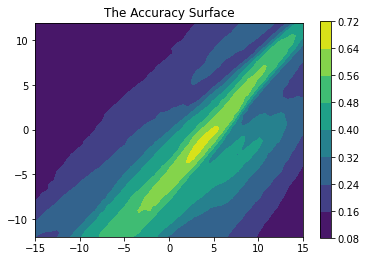

In [ ]:
xs = x_grid
ys = y_grid
zs = loss_grid
levels=5

_, ax = plt.subplots()
ax.set_title("The Accuracy Surface")
ax.set_aspect("equal")
# Set Levels
min_loss = zs.min()
max_loss = zs.max()
# levels = tf.exp(
#     tf.linspace(
#         tf.math.log(min_loss), tf.math.log(max_loss), num=levels
#     ))
levels = tf.linspace(min_loss, max_loss,num=levels)

# # Create Contour Plot
CS = ax.contourf(
    xs,
    ys,
    zs,
    #levels=levels,
    # cmap="magma",
    #linewidths=0.75,
    #norm=mpl.colors.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
)
# ax.clabel(CS, inline=True, fontsize=8, fmt="%1.2f")
_.colorbar(CS)